# Stochastic Heat PDE

$du(t,x)= \epsilon u_{xx}(t,x) dt + \sigma dW(t,x)$, $x\in [0,20]$, $t\in [0,1]$

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import SPDE
import time


In [2]:
data = scipy.io.loadmat('data/Heat_dx_64m_500t.mat')

U = data['sol'][..., :1000]
U.shape

(65, 501, 1000)

In [3]:
dx = 20/(U.shape[0]-1)
dt = 1/(U.shape[1]-1)

Dictt = []
for i in range(U.shape[2]):
    if i%100==0:
        print(i)
    U_t,Di,description = SPDE.build_linear_system(U[:,:-1,i], dt, dx, D = 5, P = 6 )
    Dictt.append(Di)
    
Dictt = np.mean(np.array(Dictt), axis=0)

0
100
200
300
400
500
600
700
800
900


In [4]:
description

['',
 'u',
 'u^2',
 'u^3',
 'u^4',
 'u^5',
 'u^6',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u^4u_{x}',
 'u^5u_{x}',
 'u^6u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u^4u_{xx}',
 'u^5u_{xx}',
 'u^6u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}',
 'u^4u_{xxx}',
 'u^5u_{xxx}',
 'u^6u_{xxx}',
 'u_{xxxx}',
 'uu_{xxxx}',
 'u^2u_{xxxx}',
 'u^3u_{xxxx}',
 'u^4u_{xxxx}',
 'u^5u_{xxxx}',
 'u^6u_{xxxx}',
 'u_{xxxxx}',
 'uu_{xxxxx}',
 'u^2u_{xxxxx}',
 'u^3u_{xxxxx}',
 'u^4u_{xxxxx}',
 'u^5u_{xxxxx}',
 'u^6u_{xxxxx}']

## **LASSO results**

In [5]:
xdt = data['xdt'].reshape(-1,order='F')
np.random.seed(11)
dxdt = xdt.reshape(1,-1)

start_time = time.time()
lam = 0.2 
Xi_drift = SPDE.Lasso(Dictt,dxdt,lam)

end_time = time.time()
print("Elapsed time: ",end_time-start_time)


/home/user/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Elapsed time:  0.524909496307373


In [6]:
Xi_act = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]
l2_error_lasso = np.linalg.norm(Xi_act-Xi_drift.reshape(-1))
print('L2 error for LASSO:   ', l2_error_lasso)

corr_ind = []
for i in range(len(Xi_act)):
    if Xi_act[i] !=0:
        corr_ind.append(i)
fp_lasso=0
for i in range(len(Xi_act)):
    if i in corr_ind:
        pass
    else:
        if Xi_drift[i] != 0:
            fp_lasso+=1
            
fpr_lasso = (fp_lasso/len(Xi_act))*100
print('False Positive Rate for LASSO (%):   ',fpr_lasso)

L2 error for LASSO:    0.564933049453742
False Positive Rate for LASSO (%):    76.19047619047619


## **SINDy results**

In [7]:
xdt = data['xdt'].reshape(-1,order='F')
np.random.seed(11)
dxdt = xdt.reshape(1,-1)

start_time = time.time()
lam = 0.2
Xi_drift = SPDE.sindy(lam,Dictt,dxdt)

end_time = time.time()
print("Elapsed time: ",end_time-start_time)

theta1 = np.zeros(16)

Elapsed time:  0.03360581398010254


In [8]:
Xi_act = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]
l2_error_sindy = np.linalg.norm(Xi_act-Xi_drift.reshape(-1))
print('L2 error for sindy:   ', l2_error_sindy)

corr_ind = []
for i in range(len(Xi_act)):
    if Xi_act[i] !=0:
        corr_ind.append(i)
fp_sindy=0
for i in range(len(Xi_act)):
    if i in corr_ind:
        pass
    else:
        if Xi_drift[i] != 0:
            fp_sindy+=1
            
fpr_sindy = (fp_sindy/len(Xi_act))*100
print('False Positive Rate for Sindy (%):   ',fpr_sindy)

L2 error for sindy:    0.0016230263777370357
False Positive Rate for Sindy (%):    0.0


## Variational Bayes

In [9]:
for i in range(len(Xi_drift)):
    if Xi_drift[i] != 0:
        Xi_drift[i] =1
initz = Xi_drift.reshape(-1)

In [10]:
X = Dictt
y = xdt.reshape(-1)
initz0 = initz.reshape(-1)
tol = 0.000001
verbosity = True

start_time = time.time()
DS = SPDE.Variational_Bayes_Code(X, y, initz0, tol, verbosity)

end_time = time.time()
print("Elapsed time: ",end_time-start_time)

# neglecting the small coefficients whose value is less than 0.01
for i in range((len(Xi_drift))):
    if abs(DS['wmean'][i])<= 0.01:
        DS['zmean'][i]=0
        DS['wmean'][i]=0
        
DS["wmean"]

/home/user/Desktop/Colaborations/Yogesh and Kalpesh/[SPDE]Yogesh/Github/Heat/SPDE.py:363: RuntimeWarning: overflow encountered in exp
  expitC = 1./(1 + np.exp(-C))
/home/user/Desktop/Colaborations/Yogesh and Kalpesh/[SPDE]Yogesh/Github/Heat/SPDE.py:335: RuntimeWarning: divide by zero encountered in log
  + np.nansum(zm*(np.log(p0) - np.log(zm)))
/home/user/Desktop/Colaborations/Yogesh and Kalpesh/[SPDE]Yogesh/Github/Heat/SPDE.py:335: RuntimeWarning: invalid value encountered in multiply
  + np.nansum(zm*(np.log(p0) - np.log(zm)))
/home/user/Desktop/Colaborations/Yogesh and Kalpesh/[SPDE]Yogesh/Github/Heat/SPDE.py:336: RuntimeWarning: divide by zero encountered in log
  + np.nansum((1-zm)*(np.log(1-p0) - np.log(1-zm))))
/home/user/Desktop/Colaborations/Yogesh and Kalpesh/[SPDE]Yogesh/Github/Heat/SPDE.py:336: RuntimeWarning: invalid value encountered in multiply
  + np.nansum((1-zm)*(np.log(1-p0) - np.log(1-zm))))


Iteration = 0  log(Likelihood) = -24079.84436962857
Iteration = 1  log(Likelihood) = -23984.577326022085
Iteration = 2  log(Likelihood) = -23984.577308677293
Iteration = 3  log(Likelihood) = -23984.57730867725
Elapsed time:  1.2636432647705078


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.99835082,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [11]:
DS['zmean']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
np.diag(DS['wCOV'])[np.where(DS['zmean'] == 1)]

array([3.43877644e-05])

In [13]:
l2_error_vb = np.linalg.norm(Xi_act-DS['wmean'])
print('L2 error for VB:   ' , l2_error_vb)

fp_vb=0
for i in range(len(Xi_act)):
    if i in corr_ind:
        pass
    else:
        if DS['wmean'][i] != 0:
            fp_vb+=1
fpr_vb = (fp_vb/len(Xi_act))*100
print('False Positive Rate for VB (%):   ',fpr_vb)

L2 error for VB:    0.0016491783028675933
False Positive Rate for VB (%):    0.0


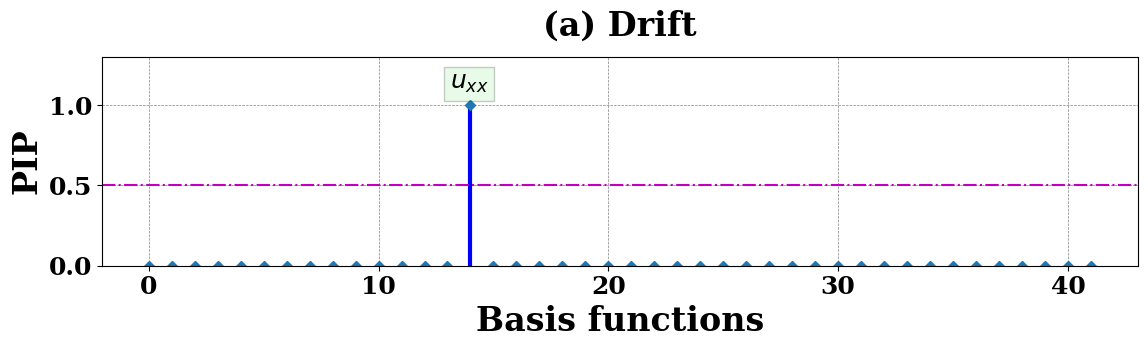

In [14]:
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 24

figure1=plt.figure(figsize = (12, 4))
xr = np.array(range(len(Xi_drift)))
plt.vlines(xr, 0, DS['zmean'], colors='blue', linewidth=3.0)
plt.plot(xr, DS['zmean'], 'C0D', markersize=5)

plt.axhline(y= 0.5, color='m', linestyle='-.')
plt.xlabel('Basis functions', fontweight='bold', fontsize=24)
plt.ylabel('PIP', fontweight='bold', fontsize=24);
plt.title('(a) Drift', fontweight='bold', fontsize=24, pad=15)
plt.grid(color='gray', linestyle='--', linewidth=0.5); plt.ylim(0,1.3)
plt.xticks(fontweight='bold', fontsize=18); plt.yticks(fontweight='bold', fontsize=18);
plt.text(13.1, 1.1, "$u_{xx}$", bbox=dict(facecolor='lightgreen', alpha=0.2), fontsize=18)
plt.tight_layout()


# Diffusion identification

## LASSO

In [15]:
xdts = data['xdiff'].reshape(-1,order='F')
np.random.seed(1)
dxdt1 = xdts.reshape(1,-1)

start_time = time.time()
lam = 0.1 
Xi_diff = SPDE.Lasso(Dictt,dxdt1,lam)

end_time = time.time()
print("Elapsed time: ",end_time-start_time)

Elapsed time:  0.4919464588165283


## SINDy

In [16]:
xdts = data['xdiff'].reshape(-1,order='F')
np.random.seed(1)
dxdt1 = xdts.reshape(1,-1)

start_time = time.time()
lam = 0.1 
Xi_diff = SPDE.sindy(lam,Dictt,dxdt1)

end_time = time.time()
print("Elapsed time: ",end_time-start_time)

Elapsed time:  0.03171586990356445


## Variational Bayes

In [17]:
for i in range(len(Xi_diff)):
    if Xi_diff[i] != 0:
        Xi_diff[i] =1
initz2 = Xi_diff.reshape(-1)

In [18]:
xdt.reshape(-1).shape

(32500,)

In [19]:
xdts.reshape(-1).shape

(32500,)

In [20]:
X = Dictt
y = xdts.reshape(-1)
initz0 = initz2.reshape(-1)
tol = 0.000001
verbosity = True

start_time = time.time()
DS1 = SPDE.Variational_Bayes_Code(X, y, initz0, tol, verbosity)

end_time = time.time()
print("Elapsed time: ",end_time-start_time)

# neglecting the small coefficients whose value is less than 0.01
for i in range((len(Xi_diff))):
    if abs(DS1['wmean'][i])<= 0.01:
        DS1['zmean'][i]=0
        DS1['wmean'][i]=0
        
np.sqrt(DS1["wmean"])

Iteration = 0  log(Likelihood) = 66184.39181054855
Iteration = 1  log(Likelihood) = 66184.3928113986
Iteration = 2  log(Likelihood) = 66184.39281139887
Elapsed time:  0.9563314914703369


array([0.99228177, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

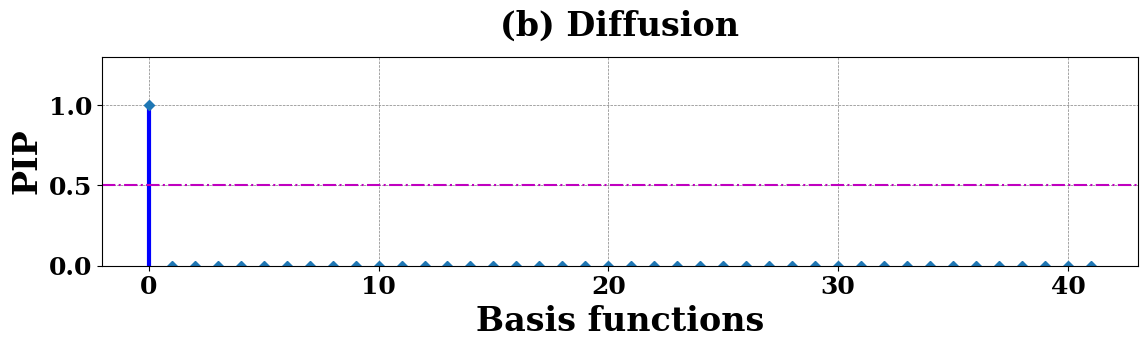

In [21]:
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 24

figure1=plt.figure(figsize = (12, 4))
xr = np.array(range(len(Xi_drift)))
plt.vlines(xr, 0, DS1['zmean'], colors='blue', linewidth=3.0)
plt.plot(xr, DS1['zmean'], 'C0D', markersize=5)
plt.axhline(y= 0.5, color='m', linestyle='-.')
plt.xlabel('Basis functions', fontweight='bold', fontsize=24)
plt.ylabel('PIP', fontweight='bold', fontsize=24);
plt.title('(b) Diffusion', fontweight='bold', fontsize=24, pad=15)
plt.grid(color='gray', linestyle='--', linewidth=0.5); plt.ylim(0,1.3)
plt.xticks(fontweight='bold', fontsize=18); plt.yticks(fontweight='bold', fontsize=18);
plt.tight_layout()


In [22]:
np.diag(DS1['wCOV'])

array([3.04704843e-08, 9.90293787e-03, 9.90293787e-03, 9.90293787e-03,
       9.90293787e-03, 9.90293787e-03, 9.90293787e-03, 9.90293787e-03,
       9.90293787e-03, 9.90293787e-03, 9.90293787e-03, 9.90293787e-03,
       9.90293787e-03, 9.90293787e-03, 9.90293787e-03, 9.90293787e-03,
       9.90293787e-03, 9.90293787e-03, 9.90293787e-03, 9.90293787e-03,
       9.90293787e-03, 9.90293787e-03, 9.90293787e-03, 9.90293787e-03,
       9.90293787e-03, 9.90293787e-03, 9.90293787e-03, 9.90293787e-03,
       9.90293787e-03, 9.90293787e-03, 9.90293787e-03, 9.90293787e-03,
       9.90293787e-03, 9.90293787e-03, 9.90293787e-03, 9.90293787e-03,
       9.90293787e-03, 9.90293787e-03, 9.90293787e-03, 9.90293787e-03,
       9.90293787e-03, 9.90293787e-03])

In [23]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 24
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

In [24]:
from matplotlib.patches import Rectangle

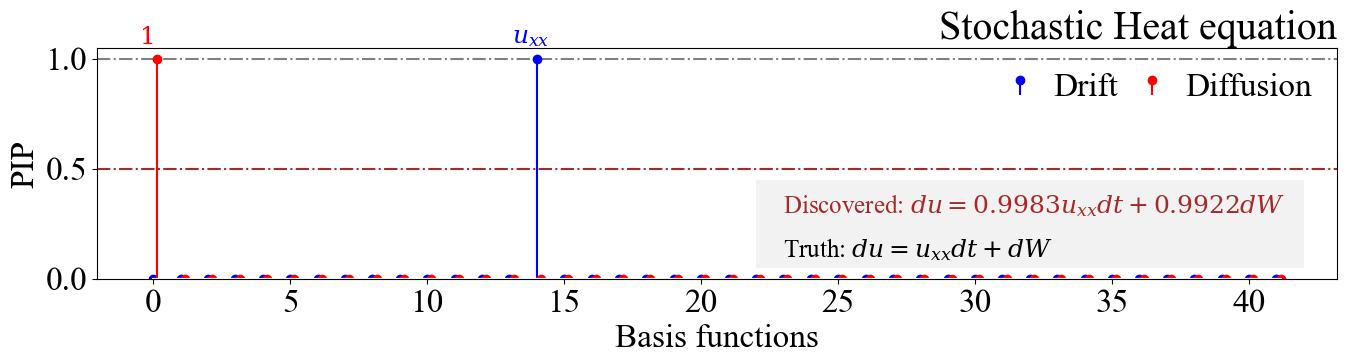

In [25]:
fig, ax = plt.subplots(figsize=(16,3))

xr = np.array(range(len(Xi_drift)))
ax.axhline(y= 1.0, color='grey', linestyle='-.')
ax.axhline(y= 0.5, color='brown', linestyle='-.')
ax.stem(xr, DS['zmean'], linefmt='b', markerfmt='ob', basefmt='w', label='Drift')
ax.stem(xr+0.15, DS1['zmean'], linefmt='r', markerfmt='or', basefmt='w', label='Diffusion')
ax.set_ylabel('PIP')
ax.set_xlabel('Basis functions')
ax.set_title('Stochastic Heat equation', loc='right')
ax.legend(ncol=2, borderpad=0.25, frameon=False, columnspacing=0.01, handletextpad=0.01)
ax.set_ylim(0,1.05)
ax.set_xticks([0,5,10,15,20,25,30,35,40])
ax.text(13.1, 1.07, "$u_{xx}$", color='b', fontsize=18)
ax.text(0, 1.07, "$1$", color='r', fontsize=18, ha='right')

ax.add_patch(Rectangle((22, 0.05), 20, 0.4, facecolor='grey', alpha=0.10))
ax.text(23,0.10, "Truth: $du = u_{xx}dt + dW$", color='k', fontsize=18)
ax.text(23,0.30, "Discovered: $du = 0.9983u_{xx}dt + 0.9922dW$", color='brown', fontsize=18)
plt.show()

fig.savefig('images/Heat_identification.pdf',format='pdf', dpi=600, bbox_inches='tight')


# Prediction graphs

In [26]:
U3 = scipy.io.loadmat('data/Heat_prediction.mat')['sol_true']
U4 = scipy.io.loadmat('data/Heat_prediction.mat')['sol_pred']


In [27]:
plt.rcParams['font.size'] = 16

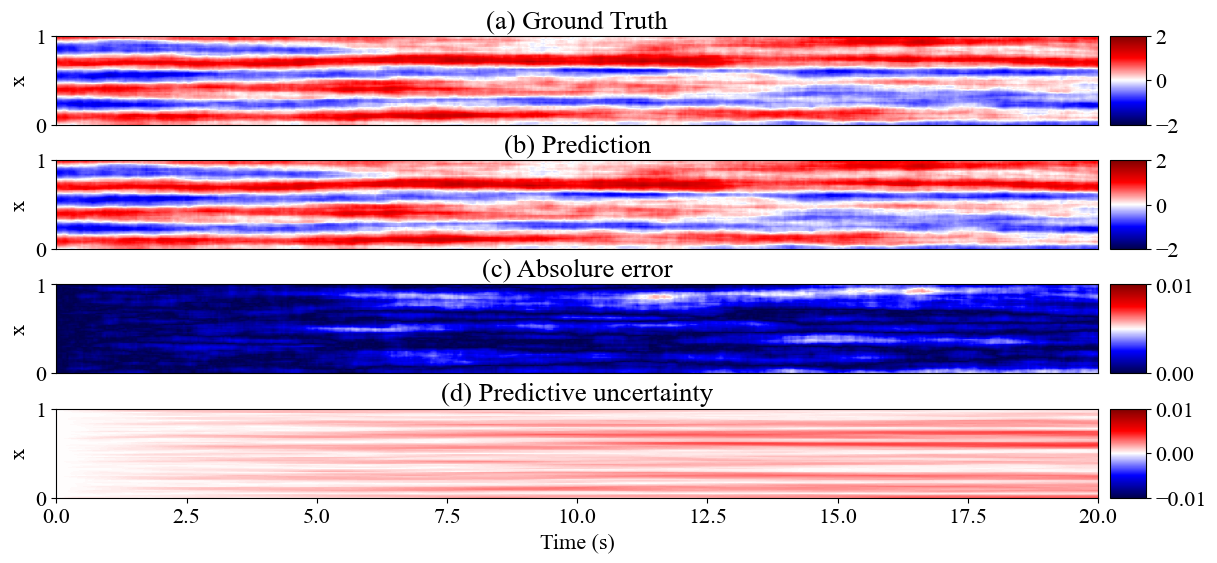

In [28]:
fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(wspace=1,hspace=0.4)
color = 'seismic'

plt.subplot(4,1,1)
uu = np.mean(U3,axis=2)
plt.imshow(uu, cmap=color, aspect='auto', origin='lower', extent=[0, 20, 0, 1], vmin=-2, vmax=2)
plt.ylabel('x');
plt.title('(a) Ground Truth')
plt.xticks([], [])
plt.colorbar(aspect=2.5, pad=0.01)

plt.subplot(4,1,2)
uu1 = np.mean(U4,axis=2)
plt.imshow(uu1, cmap=color, aspect='auto', origin='lower', extent=[0, 20, 0, 1], vmin=-2, vmax=2)
plt.ylabel('x');
plt.title('(b) Prediction')
plt.xticks([], [])
plt.colorbar(aspect=2.5, pad=0.01)

plt.subplot(4,1,3)
plt.imshow(np.abs(uu-uu1), cmap=color, aspect='auto', origin='lower', extent=[0, 20, 0, 1], vmin=0, vmax=0.01)
plt.ylabel('x');
plt.title('(c) Absolure error')
plt.xticks([], [])
plt.colorbar(aspect=2.5, pad=0.01)

plt.subplot(4,1,4)
plt.imshow(np.std(U4,axis=2), cmap=color, aspect='auto', origin='lower', extent=[0, 20, 0, 1], vmin=-0.01, vmax=0.01)
plt.xlabel('Time (s)')
plt.ylabel('x');
plt.title('(d) Predictive uncertainty')
plt.colorbar(aspect=2.5, pad=0.01)

plt.show()

fig.savefig('images/Heat_prediction.pdf',format='pdf', dpi=300, bbox_inches='tight')
